In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway
from skbio.stats.ordination import pcoa

In [2]:
concentracoes_padrao = [0.25, 0.5, 0.75, 1.0]

X = np.array(concentracoes_padrao).reshape(-1,1)

modelo = LinearRegression()

def pi_calc(L, a, b, d, f1 = 1.2, f2 = 50):
    '''Função que calcula fósforo inorgânico (Pi)
       para uma determinada leitura, com base em
       uma curva de calibração.
    
       Parâmetros:

       L: valor da leitura da amostra em absorbância
       a: coeficiente angular da reta dos padrões
       b: coeficiente linear da reta dos padrões
       d: fator de diluição do extrato
       f1: fator de diluição da leitura da amostra (2,5 mL alíquota + 0,5 mL RT)
       f2: fator de diluição solo:extrator (0,5:30)

       Retorna:

       Quantidade de P inorgânico.
    '''
    pi = ((L-b)/a)*d*f1*f2

    return pi

def calc_densidade_P(massa_g, c_mgkg, volume_dm3 = 0.1):
    """
    Calcula a densidade do solo e a concentração de fósforo em mg/dm³.

    Parâmetros:
    
    massa_g: massa da amostra em gramas.
    volume_dm3: volume da amostra em decímetros cúbicos (dm³).
    c_mgkg: concentração de fósforo em mg/kg.

    Retorna:
    
    densidade_gcm3: densidade da amostra em g/cm³.
    p_mg_dm3: concentração de fósforo em mg/dm³.
    """
    densidade_gcm3 = (massa_g / volume_dm3) / 1000

    p_mg_dm3 = c_mgkg * densidade_gcm3

    return densidade_gcm3, p_mg_dm3

### P resina. Extratora HCl 0,5 M

In [3]:
#Padrões
p025_resina = pd.read_csv('MD_P_padrao_0,25_22_09_2025.txt', encoding="cp1252", sep=",")
p05_resina = pd.read_csv('MD_P_padrao_0,5_22_09_2025.txt', encoding="cp1252", sep=",")
p075_resina = pd.read_csv('MD_P_padrao_0,75_22_09_2025.txt', encoding="cp1252", sep=",")
p1_resina = pd.read_csv('MD_P_padrao_1_22_09_2025.txt', encoding="cp1252", sep=",")

lista_padroes_resina = [p025_resina, p05_resina, p075_resina, p1_resina]

#Amostras
r1_10_resina = pd.read_csv("MD_P_amostra_R1_0-10_22_09_2025.txt", encoding="cp1252", sep=",")
r1_20_resina = pd.read_csv("MD_P_amostra_R1_10-20_22_09_2025.txt", encoding="cp1252", sep=",")
r2_10_resina = pd.read_csv("MD_P_amostra_R2_0-10_22_09_2025.txt", encoding="cp1252", sep=",")
r2_20_resina = pd.read_csv("MD_P_amostra_R2_10-20_22_09_2025.txt", encoding="cp1252", sep=",")
p2_10_resina = pd.read_csv("MD_P_amostra_P2_0-10_22_09_2025.txt", encoding="cp1252", sep=",")
p2_20_resina = pd.read_csv("MD_P_amostra_P2_10-20_22_09_2025.txt", encoding="cp1252", sep=",")

lista_amostras_resina = [r1_10_resina, r1_20_resina, r2_10_resina, r2_20_resina, p2_10_resina, p2_20_resina]

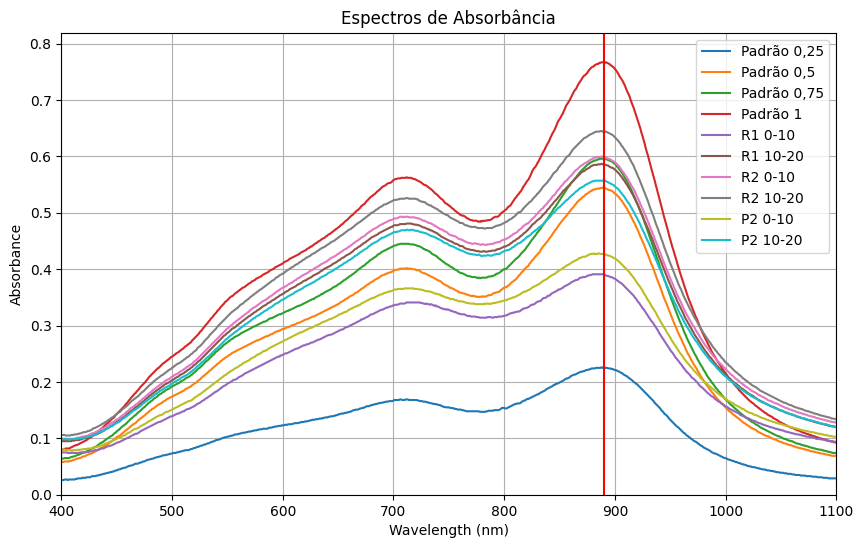

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

dataframes = [
    (p025_resina, "Padrão 0,25"),
    (p05_resina, "Padrão 0,5"),
    (p075_resina, "Padrão 0,75"),
    (p1_resina, "Padrão 1"),
    (r1_10_resina, "R1 0-10"),
    (r1_20_resina, "R1 10-20"),
    (r2_10_resina, "R2 0-10"),
    (r2_20_resina, "R2 10-20"),
    (p2_10_resina, "P2 0-10"),
    (p2_20_resina, "P2 10-20")
]

plt.figure(figsize=(10,6))

for df, label in dataframes:
    plt.plot(df["Wavelength (nm)"], df["Absorbance"], label=label)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Espectros de Absorbância")
plt.legend()
plt.xlim(400, 1100)
plt.ylim(0)
plt.grid(True)
plt.axvline(x=890, color = 'red')
plt.show()

In [5]:
#Curva de calibração
valores_padroes_resina = [max(padrao['Absorbance'].loc[(padrao['Wavelength (nm)'] <= 900) & (padrao['Wavelength (nm)']>=800)]) for padrao in lista_padroes_resina]

y_resina = valores_padroes_resina

y_resina.pop(1)

X = np.delete(X, 1, axis=0).reshape(-1, 1)

modelo.fit(X, y_resina)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


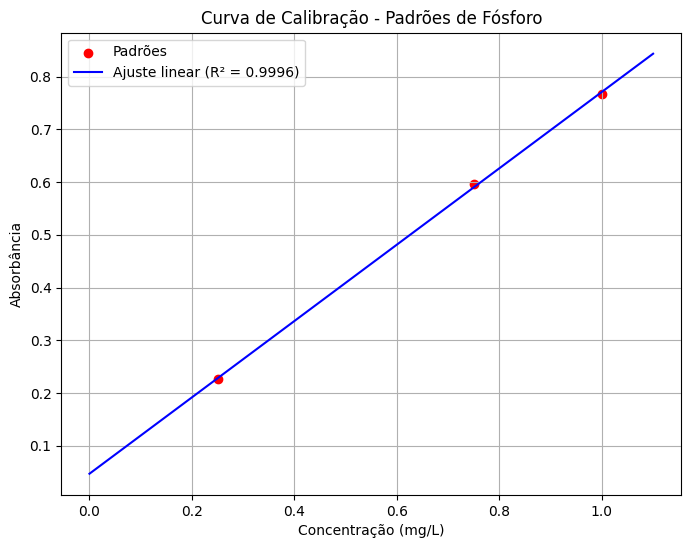

Equação da curva: Absorbância = 0.7240 * Concentração + 0.0470
R² = 0.9996


In [6]:
x_fit = np.linspace(0, 1.1, 90).reshape(-1,1)
y_fit = modelo.predict(x_fit)

r2 = modelo.score(X, y_resina)

a_resina = modelo.coef_[0]
b_resina = modelo.intercept_

plt.figure(figsize=(8,6))
plt.scatter(X, y_resina, color='red', label='Padrões')
plt.plot(x_fit, y_fit, color='blue', label=f'Ajuste linear (R² = {r2:.4f})')
plt.xlabel("Concentração (mg/L)")
plt.ylabel("Absorbância")
plt.title("Curva de Calibração - Padrões de Fósforo")
plt.legend()
plt.grid(True)
plt.show()

print(f"Equação da curva: Absorbância = {modelo.coef_[0]:.4f} * Concentração + {modelo.intercept_:.4f}")
print(f"R² = {r2:.4f}")

In [7]:
# Quantificando P resina
valores_amostras_resina = [max(amostra['Absorbance'].loc[(amostra['Wavelength (nm)'] <= 900) & (amostra['Wavelength (nm)']>=800)]) for amostra in lista_amostras_resina]

R1_0_10_resina = pi_calc(valores_amostras_resina[0], a_resina, b_resina, 1)
R1_10_20_resina = pi_calc(valores_amostras_resina[1], a_resina, b_resina, 1)
R2_0_10_resina = pi_calc(valores_amostras_resina[2], a_resina, b_resina, 1)
R2_10_20_resina = pi_calc(valores_amostras_resina[3], a_resina, b_resina, 1)
P2_0_10_resina = pi_calc(valores_amostras_resina[4], a_resina, b_resina, 1)
P2_10_20_resina = pi_calc(valores_amostras_resina[5], a_resina, b_resina, 1)


massa_R1_0_10  = 190.229   
massa_R1_10_20 = 230.149
massa_R2_0_10  = 204.355
massa_R2_10_20 = 243.412
massa_P2_0_10  = 211.802
massa_P2_10_20 = 219.833

densidades = []
valores_mg_dm3 = []

dens_R1010, p_R1010 = calc_densidade_P(massa_R1_0_10,  R1_0_10_resina)
densidades.append(dens_R1010); valores_mg_dm3.append(p_R1010)

dens_R11020, p_R11020 = calc_densidade_P(massa_R1_10_20, R1_10_20_resina)
densidades.append(dens_R11020); valores_mg_dm3.append(p_R11020)

dens_R2010, p_R2010 = calc_densidade_P(massa_R2_0_10,  R2_0_10_resina)
densidades.append(dens_R2010); valores_mg_dm3.append(p_R2010)

dens_R21020, p_R21020 = calc_densidade_P(massa_R2_10_20, R2_10_20_resina)
densidades.append(dens_R21020); valores_mg_dm3.append(p_R21020)

dens_P2010, p_P2010 = calc_densidade_P(massa_P2_0_10,  P2_0_10_resina)
densidades.append(dens_P2010); valores_mg_dm3.append(p_P2010)

dens_P21020, p_P21020 = calc_densidade_P(massa_P2_10_20, P2_10_20_resina)
densidades.append(dens_P21020); valores_mg_dm3.append(p_P21020)

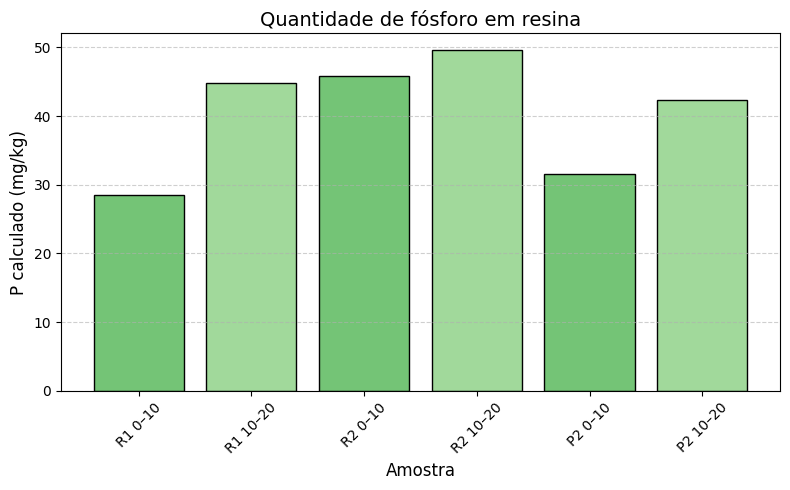

In [8]:
valores = [
    R1_0_10_resina,
    R1_10_20_resina,
    R2_0_10_resina,
    R2_10_20_resina,
    P2_0_10_resina,
    P2_10_20_resina
]

labels = [
    'R1 0–10',
    'R1 10–20',
    'R2 0–10',
    'R2 10–20',
    'P2 0–10',
    'P2 10–20'
]

plt.figure(figsize=(8, 5))
plt.bar(labels, valores, color=['#74c476', '#a1d99b'], edgecolor='black')

plt.title('Quantidade de fósforo em resina', fontsize=14)
plt.ylabel('P calculado (mg/kg)', fontsize=12)
plt.xlabel('Amostra', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

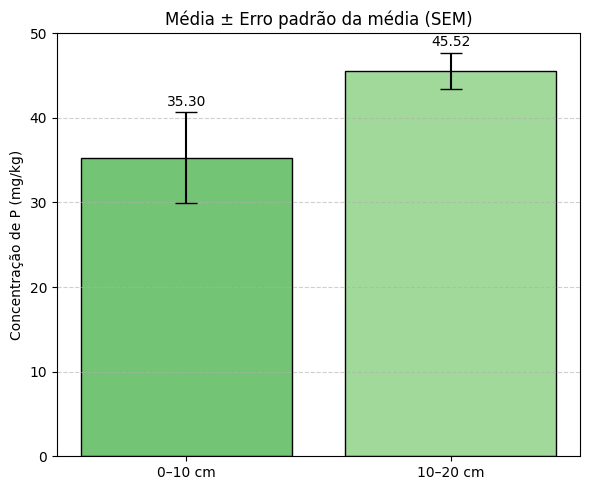

In [9]:
pi_0_10 = np.array([
    R1_0_10_resina,
    R2_0_10_resina,
    P2_0_10_resina
])

pi_10_20 = np.array([
    R1_10_20_resina,
    R2_10_20_resina,
    P2_10_20_resina
])

means = [pi_0_10.mean(), pi_10_20.mean()]
stds = [pi_0_10.std(ddof=1), pi_10_20.std(ddof=1)]  # desvio padrão
ns = [len(pi_0_10), len(pi_10_20)]
sems = [stds[i] / np.sqrt(ns[i]) for i in range(2)]  # erro padrão da média

labels = ['0–10 cm', '10–20 cm']
x = np.arange(len(labels))

plt.figure(figsize=(6, 5))
plt.bar(x, means, yerr=sems, capsize=8, color=['#74c476', '#a1d99b'], edgecolor='black')

plt.xticks(x, labels)
plt.ylabel('Concentração de P (mg/kg)')
plt.title('Média ± Erro padrão da média (SEM)')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, v in enumerate(means):
    plt.text(i, v + sems[i] + 0.01 * v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
pi_0_10 = np.array([R1_0_10_resina, R2_0_10_resina, P2_0_10_resina])
pi_10_20 = np.array([R1_10_20_resina, R2_10_20_resina, P2_10_20_resina])

F_stat, p_value = f_oneway(pi_0_10, pi_10_20)
print(f"F = {F_stat:.3f}, p = {p_value:.4f}")

F = 3.160, p = 0.1501


R1 0–10: densidade = 1.9023 g/cm³  |  28.51 mg/kg  ->  54.23 mg/dm³
R1 10–20: densidade = 2.3015 g/cm³  |  44.75 mg/kg  ->  102.99 mg/dm³
R2 0–10: densidade = 2.0435 g/cm³  |  45.83 mg/kg  ->  93.65 mg/dm³
R2 10–20: densidade = 2.4341 g/cm³  |  49.56 mg/kg  ->  120.63 mg/dm³
P2 0–10: densidade = 2.1180 g/cm³  |  31.57 mg/kg  ->  66.88 mg/dm³
P2 10–20: densidade = 2.1983 g/cm³  |  42.27 mg/kg  ->  92.91 mg/dm³


C:\Users\davi23037\AppData\Local\Temp\ipykernel_27428\3276902418.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)
C:\Users\davi23037\AppData\Local\Temp\ipykernel_27428\3276902418.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45)


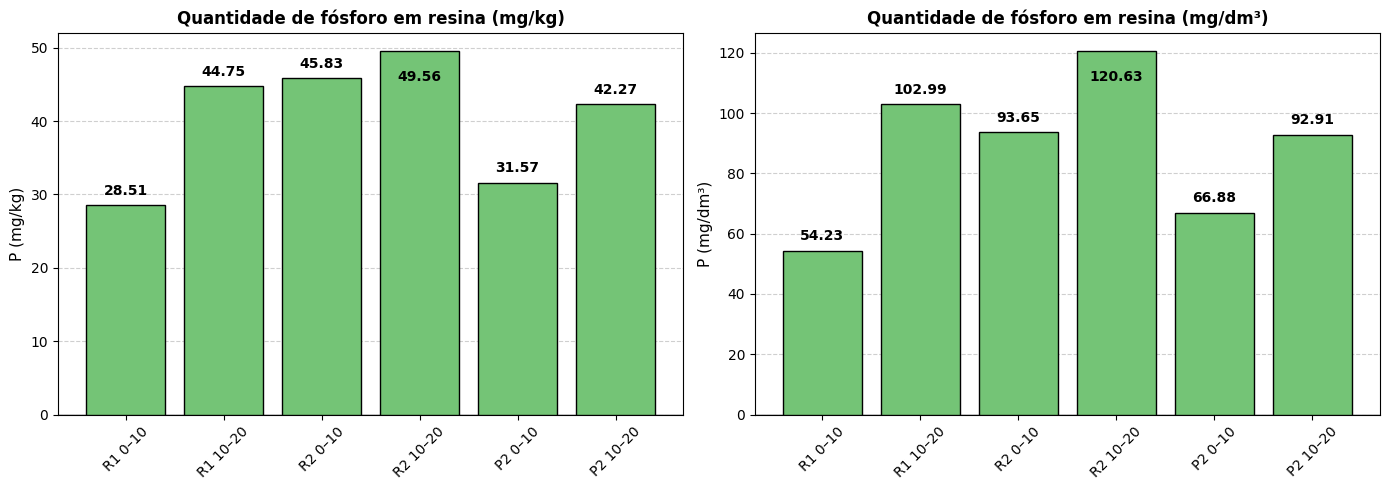

In [11]:
import matplotlib.pyplot as plt
import numpy as np

valores_mgkg = np.array([
    R1_0_10_resina,
    R1_10_20_resina,
    R2_0_10_resina,
    R2_10_20_resina,
    P2_0_10_resina,
    P2_10_20_resina
], dtype=float)

valores_mg_dm3 = np.array(valores_mg_dm3, dtype=float)
densidades = np.array(densidades, dtype=float)

for label, dens, mgkg, mgdm3 in zip(
        ['R1 0–10','R1 10–20','R2 0–10','R2 10–20','P2 0–10','P2 10–20'],
        densidades, valores_mgkg, valores_mg_dm3):
    print(f"{label}: densidade = {dens:.4f} g/cm³  |  {mgkg:.2f} mg/kg  ->  {mgdm3:.2f} mg/dm³")

labels = [
    'R1 0–10',
    'R1 10–20',
    'R2 0–10',
    'R2 10–20',
    'P2 0–10',
    'P2 10–20'
]

def colors_for(vals):
    return ['#74c476' if v >= 0 else '#d9d9d9' for v in vals]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# gráfico 1: mg/kg 
ax = axes[0]
colors1 = colors_for(valores_mgkg)
bars1 = ax.bar(labels, valores_mgkg, color=colors1, edgecolor='black', zorder=3)
ax.set_title('Quantidade de fósforo em resina (mg/kg)', fontsize=12, fontweight='bold')
ax.set_ylabel('P (mg/kg)', fontsize=11)
ax.set_xticklabels(labels, rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
ax.axhline(0, color='black', linewidth=1.0)

#"Não mensurável" quando negativo (mg/kg)
ymax1 = ax.get_ylim()[1]
for i, v in enumerate(valores_mgkg):
    if v < 0:
        ax.text(i, ymax1 * 0.05, 'Não mensurável', ha='center', va='bottom',
                fontsize=9, color='black', fontweight='bold', rotation=90)
    else:
        y_text = v + ymax1 * 0.02  # deslocamento proporcional ao limite do eixo
        if y_text > ymax1 * 0.95:  # evita que passe do topo
            y_text = v - ymax1 * 0.05  # coloca o texto dentro da barra
            va = 'top'
        else:
            va = 'bottom'
        ax.text(i, y_text, f'{v:.2f}', ha='center', va=va,
                fontsize=10, fontweight='bold', color='black')


# gráfico 2: mg/dm^3
ax2 = axes[1]
colors2 = colors_for(valores_mg_dm3)
bars2 = ax2.bar(labels, valores_mg_dm3, color=colors2, edgecolor='black', zorder=3)
ax2.set_title('Quantidade de fósforo em resina (mg/dm³)', fontsize=12, fontweight='bold')
ax2.set_ylabel('P (mg/dm³)', fontsize=11)
ax2.set_xticklabels(labels, rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
ax2.axhline(0, color='black', linewidth=1.0)

#"Não mensurável" quando negativo (mg/dm3)
ymax2 = ax2.get_ylim()[1]
for i, v in enumerate(valores_mg_dm3):
    if v < 0:
        ax2.text(i, ymax2 * 0.05, 'Não mensurável', ha='center', va='bottom',
                 fontsize=9, color='black', fontweight='bold', rotation=90)
    else:
        y_text = v + ymax2 * 0.02
        if y_text > ymax2 * 0.95:
            y_text = v - ymax2 * 0.05
            va = 'top'
        else:
            va = 'bottom'
        ax2.text(i, y_text, f'{v:.2f}', ha='center', va=va,
                 fontsize=10, fontweight='bold', color='black')
plt.tight_layout()
plt.show()

In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Função auxiliar de cores ---
def colors_for(valores):
    return ['#74c476' if v >= 0 else '#d9d9d9' for v in valores]

# --- Subplots lado a lado ---
fig = make_subplots(rows=1, cols=2, subplot_titles=[
    'Quantidade de fósforo em resina (mg/kg)',
    'Quantidade de fósforo em resina (mg/dm³)'
])

# --- Gráfico 1: mg/kg ---
colors1 = colors_for(valores_mgkg)
fig.add_trace(
    go.Bar(
        x=labels,
        y=valores_mgkg,
        text=[f'{v:.2f}' if v >= 0 else 'Não mensurável' for v in valores_mgkg],
        textposition=['outside' if v >= 0 else 'inside' for v in valores_mgkg],
        textfont=dict(size=11, color=['black' if v >= 0 else 'white' for v in valores_mgkg]),
        marker_color=colors1,
        name='mg/kg'
    ),
    row=1, col=1
)

# --- Gráfico 2: mg/dm³ ---
colors2 = colors_for(valores_mg_dm3)
fig.add_trace(
    go.Bar(
        x=labels,
        y=valores_mg_dm3,
        text=[f'{v:.2f}' if v >= 0 else 'Não mensurável' for v in valores_mg_dm3],
        textposition=['outside' if v >= 0 else 'inside' for v in valores_mg_dm3],
        textfont=dict(size=11, color=['black' if v >= 0 else 'white' for v in valores_mg_dm3]),
        marker_color=colors2,
        name='mg/dm³'
    ),
    row=1, col=2
)

# --- Layout geral ---
fig.update_layout(
    height=500,
    width=1000,
    showlegend=False,
    title_text="Comparação de fósforo em resina (mg/kg e mg/dm³)",
    title_x=0.5,
    bargap=0.3,
    plot_bgcolor='white',
    font=dict(size=12)
)

# Linhas de referência no zero
fig.update_yaxes(showgrid=True, gridcolor='lightgray', zeroline=True, zerolinecolor='black')

fig.show()


C:\Users\davi23037\AppData\Roaming\Python\Python310\site-packages\kaleido\__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




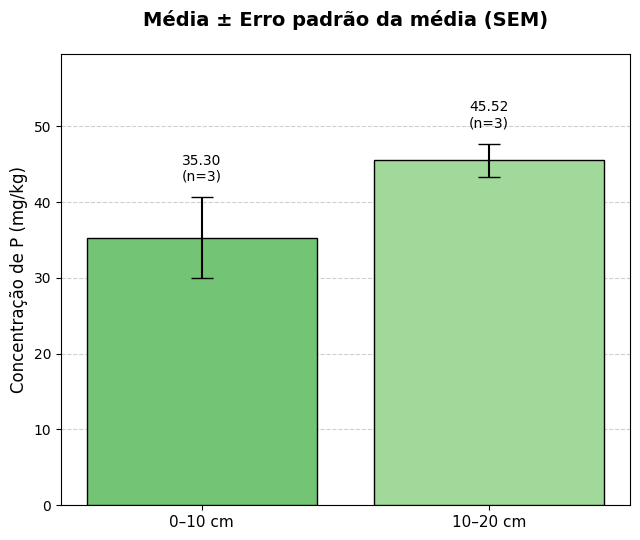

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Função para limpar valores negativos (não mensuráveis)
def limpar(valores):
    arr = np.array(valores, dtype=float)
    arr[arr < 0] = np.nan
    return arr

# Dados
pi_0_10 = limpar([
    R1_0_10_resina,
    R2_0_10_resina,
    P2_0_10_resina
])

pi_10_20 = limpar([
    R1_10_20_resina,
    R2_10_20_resina,
    P2_10_20_resina
])

# Estatísticas
means = [np.nanmean(pi_0_10), np.nanmean(pi_10_20)]
stds = [np.nanstd(pi_0_10, ddof=1), np.nanstd(pi_10_20, ddof=1)]
ns = [np.sum(~np.isnan(pi_0_10)), np.sum(~np.isnan(pi_10_20))]
sems = [stds[i] / np.sqrt(ns[i]) if ns[i] > 0 else np.nan for i in range(2)]

# Gráfico
labels = ['0–10 cm', '10–20 cm']
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(6.5, 5.5))
bars = ax.bar(x, means, yerr=sems, capsize=8, color=['#74c476', '#a1d99b'], edgecolor='black', zorder=3)

# Grade e eixos
ax.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel('Concentração de P (mg/kg)', fontsize=12)
ax.set_title('Média ± Erro padrão da média (SEM)', fontsize=14, fontweight='bold', pad=20)

# Ajusta limites do gráfico para dar espaço ao texto acima das barras
ymax = np.nanmax(means + np.nan_to_num(sems)) * 1.25
ax.set_ylim(0, ymax)

# Anotações
for i, (v, sem, n) in enumerate(zip(means, sems, ns)):
    if not np.isnan(v):
        ax.text(i, v + (sem if not np.isnan(sem) else 0) + 0.03 * ymax,
                f'{v:.2f}\n(n={n})', ha='center', va='bottom', fontsize=10, fontweight='medium')
    else:
        ax.text(i, ymax * 0.05, 'Não mensurável', ha='center', va='bottom',
                fontsize=10, color='red', fontweight='bold')

# Deixa o layout equilibrado
plt.tight_layout()
plt.show()


In [14]:
import numpy as np
import plotly.graph_objects as go

# Função para limpar valores negativos (não mensuráveis)
def limpar(valores):
    arr = np.array(valores, dtype=float)
    arr[arr < 0] = np.nan
    return arr

# Dados
pi_0_10 = limpar([R1_0_10_resina, R2_0_10_resina, P2_0_10_resina])
pi_10_20 = limpar([R1_10_20_resina, R2_10_20_resina, P2_10_20_resina])

# Estatísticas
means = [np.nanmean(pi_0_10), np.nanmean(pi_10_20)]
stds  = [np.nanstd(pi_0_10, ddof=1), np.nanstd(pi_10_20, ddof=1)]
ns    = [np.sum(~np.isnan(pi_0_10)), np.sum(~np.isnan(pi_10_20))]
sems  = [stds[i] / np.sqrt(ns[i]) if ns[i] > 0 else np.nan for i in range(2)]

# Labels e cores
labels = ['0–10 cm', '10–20 cm']
colors = ['#74c476', '#a1d99b']

# Calcula a posição do texto acima da barra + erro
text_y = []
text_labels = []
for v, sem, n in zip(means, sems, ns):
    if np.isnan(v):
        text_y.append(0.05 * max(means))  # posição mínima
        text_labels.append('Não mensurável')
    else:
        text_y.append(v + (sem if not np.isnan(sem) else 0) + 0.03*max(means))  # acima da barra + erro
        text_labels.append(f'{v:.2f}\n(n={n})')

# Criar gráfico
fig = go.Figure()

fig.add_trace(go.Bar(
    x=labels,
    y=means,
    error_y=dict(
        type='data',
        array=sems,
        visible=True,
        thickness=2,
        width=8
    ),
    marker_color=colors,
    text=text_labels,
    textposition='none',  # não usar outside, vamos posicionar manualmente
))

# Adiciona os textos manualmente acima da barra + erro
for xi, yi, txt in zip(labels, text_y, text_labels):
    fig.add_annotation(
        x=xi,
        y=yi,
        text=txt,
        showarrow=False,
        font=dict(size=12, color='black'),
        xanchor='center',
        yanchor='bottom'
    )

# Layout
fig.update_layout(
    title='Média ± Erro padrão da média (SEM)',
    title_font_size=16,
    yaxis_title='Concentração de P (mg/kg)',
    xaxis_title='Profundidade',
    plot_bgcolor='white',
    bargap=0.4,
    yaxis=dict(showgrid=True, gridcolor='lightgray', zeroline=True, zerolinecolor='black'),
)

fig.show()


In [15]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Função para limpar valores negativos (não mensuráveis)
def limpar(valores):
    arr = np.array(valores, dtype=float)
    arr[arr < 0] = np.nan
    return arr

# --- Dados mg/kg ---
pi_0_10_mgkg = limpar([R1_0_10_resina, R2_0_10_resina, P2_0_10_resina])
pi_10_20_mgkg = limpar([R1_10_20_resina, R2_10_20_resina, P2_10_20_resina])

# --- Dados mg/dm³ ---
pi_0_10_mgdm3 = limpar([calc_densidade_P(R1_0_10_resina, c_mgkg=R1_0_10_resina)[1],
                        calc_densidade_P(R2_0_10_resina, c_mgkg=R2_0_10_resina)[1],
                        calc_densidade_P(P2_0_10_resina, c_mgkg=P2_0_10_resina)[1]])

pi_10_20_mgdm3 = limpar([calc_densidade_P(R1_10_20_resina, c_mgkg=R1_10_20_resina)[1],
                         calc_densidade_P(R2_10_20_resina, c_mgkg=R2_10_20_resina)[1],
                         calc_densidade_P(P2_10_20_resina, c_mgkg=P2_10_20_resina)[1]])

# --- Estatísticas ---
def calcular_estatisticas(dados):
    mean = np.nanmean(dados)
    std = np.nanstd(dados, ddof=1)
    n = np.sum(~np.isnan(dados))
    sem = std / np.sqrt(n) if n > 0 else np.nan
    return mean, sem, n

means_mgkg, sems_mgkg, ns_mgkg = zip(*[calcular_estatisticas(pi_0_10_mgkg),
                                       calcular_estatisticas(pi_10_20_mgkg)])
means_mgdm3, sems_mgdm3, ns_mgdm3 = zip(*[calcular_estatisticas(pi_0_10_mgdm3),
                                          calcular_estatisticas(pi_10_20_mgdm3)])

# Labels e cores
labels = ['0–10 cm', '10–20 cm']
colors = ['#74c476', '#a1d99b']

# --- Criar subplots lado a lado ---
fig = make_subplots(rows=1, cols=2, subplot_titles=[
    'Quantidade de fósforo em resina (mg/kg)',
    'Quantidade de fósforo em resina (mg/dm³)'
])

# --- Função auxiliar para adicionar texto acima da barra + erro ---
def criar_textos(means, sems, ns):
    textos = []
    y_pos = []
    max_val = max([m + s for m, s in zip(means, sems) if not np.isnan(m)])
    for m, s, n in zip(means, sems, ns):
        if np.isnan(m):
            textos.append('Não mensurável')
            y_pos.append(0.05 * max_val)
        else:
            textos.append(f'{m:.2f}\n(n={n})')
            y_pos.append(m + s + 0.03*max_val)  # deslocamento acima da barra + erro
    return textos, y_pos

texts_mgkg, y_mgkg = criar_textos(means_mgkg, sems_mgkg, ns_mgkg)
texts_mgdm3, y_mgdm3 = criar_textos(means_mgdm3, sems_mgdm3, ns_mgdm3)

# --- Gráfico mg/kg ---
fig.add_trace(go.Bar(
    x=labels,
    y=means_mgkg,
    error_y=dict(type='data', array=sems_mgkg, visible=True, thickness=2, width=8),
    marker_color=colors,
    text=texts_mgkg,
    textposition='none',
), row=1, col=1)

# --- Adiciona anotações acima da barra + erro (mg/kg) ---
for xi, yi, txt in zip(labels, y_mgkg, texts_mgkg):
    fig.add_annotation(
        x=xi,
        y=yi,
        text=txt,
        showarrow=False,
        font=dict(size=12, color='black'),
        xanchor='center',
        yanchor='bottom',
        row=1, col=1
    )

# --- Gráfico mg/dm³ ---
fig.add_trace(go.Bar(
    x=labels,
    y=means_mgdm3,
    error_y=dict(type='data', array=sems_mgdm3, visible=True, thickness=2, width=8),
    marker_color=colors,
    text=texts_mgdm3,
    textposition='none',
), row=1, col=2)

# --- Adiciona anotações acima da barra + erro (mg/dm³) ---
for xi, yi, txt in zip(labels, y_mgdm3, texts_mgdm3):
    fig.add_annotation(
        x=xi,
        y=yi,
        text=txt,
        showarrow=False,
        font=dict(size=12, color='black'),
        xanchor='center',
        yanchor='bottom',
        row=1, col=2
    )
# --- Layout ---
fig.update_layout(
    height=500,
    width=1000,
    showlegend=False,
    title_text="Comparação de fósforo em resina (mg/kg e mg/dm³)",
    title_x=0.5,
    bargap=0.3,
    plot_bgcolor='white',
    font=dict(size=12)
)

# Linhas de referência no zero
fig.update_yaxes(showgrid=True, gridcolor='lightgray', zeroline=True, zerolinecolor='black')

fig.show()
